#Bibliotecas

##Instalação

In [ ]:
!pip install qiskit
!pip install qiskit-aer
!pip install qiskit-ibm-runtime
!pip install qiskit-ibmq-provider
!pip install pylatexenc
from qiskit_ibm_runtime import QiskitRuntimeService


QiskitRuntimeService.save_account(channel='ibm_quantum', overwrite=True, instance='ibm-q/open/main', token='YOUR TOKEN')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 17.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243

##Importação

In [ ]:
from qiskit import QuantumCircuit, Aer, transpile, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info.operators import Operator, Pauli
from numpy import pi, sin, cos, array, dot, outer, transpose, conjugate, delete, sum, std,mean
from numpy.random import randint
from numpy.linalg import eigh
import matplotlib.pyplot as plt
import matplotlib as mpl


#Protocolo E91 sem invasor e sem ruído

#Preparando as funções

#Etapa 1: Charlie cria o estado EPR

Criação do estado de Bell $|\psi^-⟩=\dfrac{1}{\sqrt{2}}(|01⟩-|10⟩)$, que será enviado para Alice e Bob



In [ ]:
# Função que emaranha o qbit 'qbit1' com o qbit 'qbit2' de cada circuito de uma mensagem
def criar_EPR(mensagem,qbit1=0, qbit2=1):
  for i in range(len(mensagem)):
    mensagem[i].h(0)
    mensagem[i].x(1)
    mensagem[i].cx(0,1)
    mensagem[i].z(1)

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


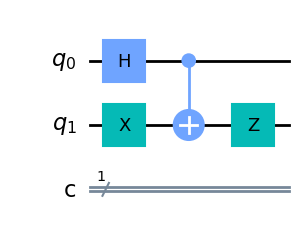

                                                           Estado final:


<IPython.core.display.Latex object>

In [ ]:
# Exemplo de aplicação
# Criaremos uma lista de n itens, em que cada um desses ítens corresponde a um circuito de ermaranhamento
n=10 #Número de pares EPR distribuídos

mensagem=[]
for i in range(n):
  qc=QuantumCircuit(2,1)
  mensagem.append(qc)

criar_EPR(qbit1=0,qbit2=1,mensagem=mensagem)

display(mensagem[0].draw('mpl')) #Desenhando o primeiro ciruito da mensagem

# Executa o emulador para o primeiro circuito,  e imprime o estado final do par EPR sem realizar a medida
statevector_simulator = Aer.get_backend('statevector_simulator')
job = statevector_simulator.run(mensagem[0])
state1 = job.result().get_statevector()
print("                                                           Estado final:")
state1.draw('latex')

Assim, criamos n pares EPR e serão enviados para alice e bob

#Etapa 2: Bob e Alice realizam a medida

##Definição das direções de medida

Aqui definiremos as direções das bases em que Alice e Bob projetarão a medida do spin, cada um possuirá 3 vetores, como os vetores são unitários, eles definidos apenas por seus ângulos θ e $\phi$

###Direções de medida da Alice

In [ ]:
# Vetores que determinam as diferentes direções que alice projetará o spin
a1=[pi/2,0]
a2=[pi/2,pi/4]
a3=[pi/2,pi/2]

# Esses 3 votores formam a projeções de Alice
vetores_alice=[a1,a2,a3]

###Direções de medida de Bob

Bob fará o processo análogo para sua projeções:

In [ ]:
b1=[pi/2,pi/4]
b2=[pi/2,pi/2]
b3=[pi/2,3*pi/4]

vetores_bob=[b1,b2,b3]


##Desafio da medida no qiskit

O qiskit apresenta apenas porjeção de spin na direção $\hat{z}$, então precisamos realizar uma operação unitária $U_n$ que faça a equivalência entre a projeção em $\hat{z}$ e a direção arbitrária $\hat{n}$

$$U_n=|{0_z}⟩ \langle{0_n}|+|{1_z}⟩ \langle{1_n}|$$

N função abaixo você vornece uma lista de 3 direções, e ela retorna uma lista de operações $U_n$ para cada uma delas, respectivamente.

In [ ]:
def obter_rotacoes(vetores):
  Px=Operator(Pauli('Z'))
  Py=Operator(Pauli('X'))
  Pz=Operator(Pauli('Y'))

  rotacoes=[]

  for i in range(len(vetores)):
    ket0=[1,0]
    ket1=[0,1]

    theta=vetores[i][0]
    phi=vetores[i][1]

    sigma=sin(theta)*cos(phi)*Px+sin(phi)*sin(theta)*Py+cos(theta)*Pz
    autovalor,autovetor=eigh(sigma)
    v0=autovetor[:,1]
    v1=autovetor[:,0]
    brav0=conjugate(v0).transpose()
    brav1=conjugate(v1).transpose()

    ket0=[1,0]
    ket1=[0,1]

    operador= outer(ket0,brav0) +outer(ket1,brav1)
    rotacoes.append(operador)


  return rotacoes

##A realização da medita

A função a seguir recebe a mensagem contanto dos qbits, e realiza em cada um dos enésimos qbits a enésima projeção  escolhida (contida na lista ''escolhas'')

O parâmetro operadores corresponde a lista de $U_n$'s operadores definidos anteriormente
Os parâmetro qbit e cbit correspondem a qual qbit será realizado a medida, e em quam cbit ela será armazenada

In [ ]:
def medir_qbit(mensagem,escolhas, operadores, qbit, cbit, text='Op'):
  for i in range(len(mensagem)):
    rotacao=operadores[escolhas[i]]
    mensagem[i].barrier()
    mensagem[i].unitary(rotacao,[qbit], label='$'+text+str(escolhas[i])+'$')
    mensagem[i].measure(qbit,cbit)


A escolha de medidas é feita por:

In [ ]:
escolhas_alice=randint(3, size=n)
escolhas_bob=randint(3, size=n)

O enésimo item dessas listas determina a direção em que cada um fará a medida do enésimo qbit, da seguinte forma:

0 → projeta em a1 (b1)

1 → projeta em a2 (b2)

2 → projeta em a3 (b3)

A função "medir_qbit" é quem identifica isso

##A simulação

A função definida a seguir tem o papel de gerar a simulação de cada um dos circuitos da mensagem, ela retornará um json com chave e valor no formato:

{'usuario1': [string de bits]
'usuario2': [string de bits]
...}

Lembre-se de ordenar a lista de usuários na mesma ordem que as medidas são feitas

In [ ]:
def simular_mensagem (mensagem, usuarios=['Alice', 'Bob']):
  resultado_medidas={}

  for usuario in usuarios:
    resultado_medidas[usuario]=[]
  # for i in resultado_medidas:
  #   print(resultado_medidas[i])


  for i in range(len(mensagem)):
    # Execura o simulador do circuito
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(mensagem[i], simulator, shots=1).result()

    # Obtenha as contagens
    counts = result.get_counts()
    #O método .het_counts() retorna chave valor no formato json com \\
    #a chave sendo o resultado das medidas e o valor o número de vezes que esse desultado foi obtido

    estado= list(counts.keys())[0] #Só nos interessa a chave, pois estado sempre simulando 1 shot
    for i in range(len(estado)):
      resultado_medidas[usuarios[i]].append(int(estado[i]))


  return resultado_medidas

Até o momento o processo é:

In [ ]:
# Determinação das diferentes direções que alice projetará o spin
a1=[pi/2,0]
a2=[pi/2,pi/4]
a3=[pi/2,pi/2]
vetores_alice=[a1,a2,a3]
operador_alice=obter_rotacoes(vetores_alice)

# Determinação das diferentes direções que alice projetará o spin
b1=[pi/2,pi/4]
b2=[pi/2,pi/2]
b3=[pi/2,3*pi/4]
vetores_bob=[b1,b2,b3]
operador_bob=obter_rotacoes(vetores_bob)


# ------------------------Etapa 1---------------------------------
n=300
mensagem=[]
for i in range(n):
  qc=QuantumCircuit(2,2)
  mensagem.append(qc)

criar_EPR(mensagem) #Criação dos n pares emaranhados

# ------------------------Etapa 2---------------------------------
escolhas_alice=randint(3, size=n) #Alice decide sua sequencia de medida
escolhas_bob=randint(3, size=n) #Bob decide sua sequencia de medida

medir_qbit(mensagem, escolhas_alice, operador_alice, qbit=0,cbit=0,text='A(a_') #Alcie realiza a projeção
medir_qbit(mensagem, escolhas_bob, operador_bob, qbit=1,cbit=1,text='B(b_') #Bob realiza a projeção

resultado_medidas=simular_mensagem (mensagem, usuarios=['Alice', 'Bob'])

Como dito antes, cada item da mensagem é um circuito quântico, vamos visualizar o processo de envio e medida dos 10 primeiros pares EPR que foram criados na célula acima. Note que acima dele será impresso a base utilizada e o bit que foi medido, mas note que se a operação escolhida por Alice for A_2 e por Bob B_1, ou se A_3 e B_2, o resultado será sempre antcorrelacionado, mas nas demais combinações isso não acontece. Voce pode forçar que aparece todas as combinações possiveis de escolhas passando os parâmetros:
```
escolhas_alice=[0,1,2,0,1,2,0,1,2]
escolhas_bob=  [0,1,2,2,0,1,1,2,1]
```
no lugar de:
```
escolhas_alice=randint(3, size=n)
escolhas_bob=randint(3, size=n)
```
mas lembre-se de definir n=9, caso contrário obterá
```
IndexError: list index out of range
```

Obs.: O que se encontra antes da primeira barreira, é a criação d par EPR, entre as barreiras as operações de Alice, e após a barreira as operações de Bob.


        Bit Alice:0

        Bit Bob:0
        


/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


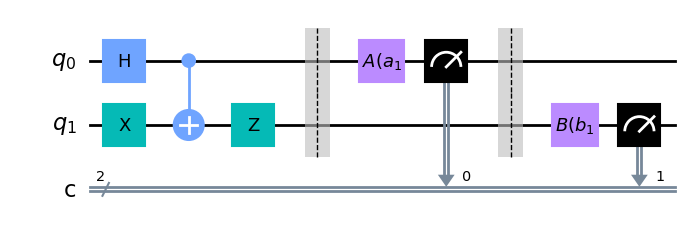


        Bit Alice:1

        Bit Bob:0
        


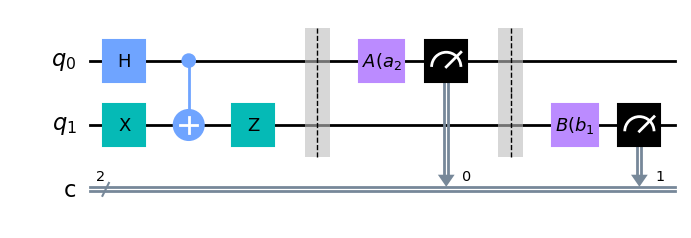


        Bit Alice:1

        Bit Bob:0
        


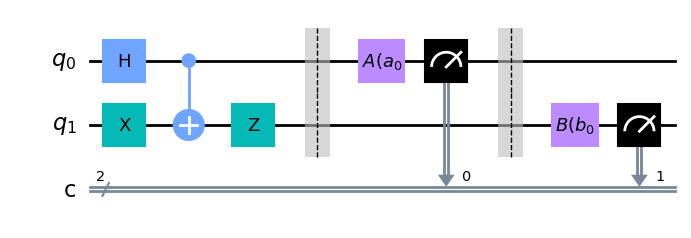


        Bit Alice:1

        Bit Bob:0
        


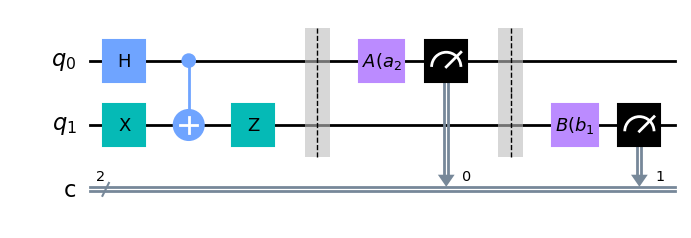


        Bit Alice:0

        Bit Bob:1
        


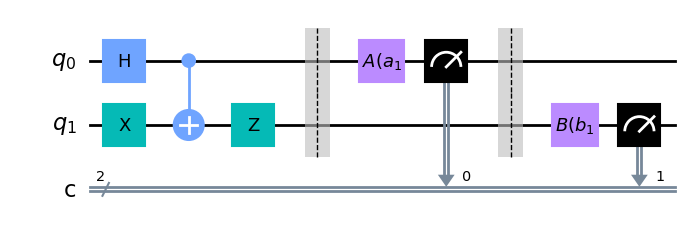


        Bit Alice:1

        Bit Bob:0
        


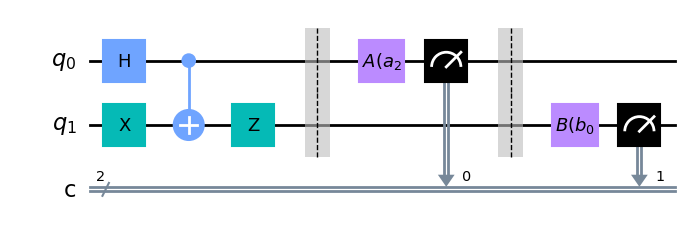


        Bit Alice:0

        Bit Bob:1
        


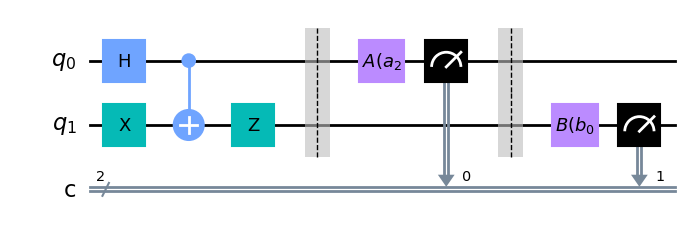


        Bit Alice:0

        Bit Bob:0
        


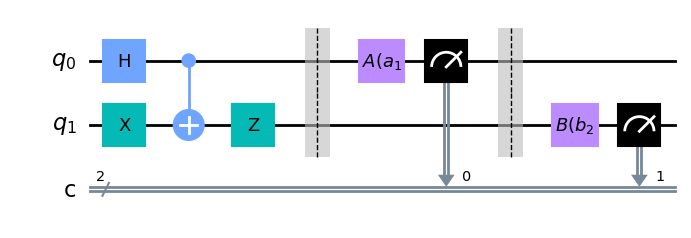


        Bit Alice:0

        Bit Bob:0
        


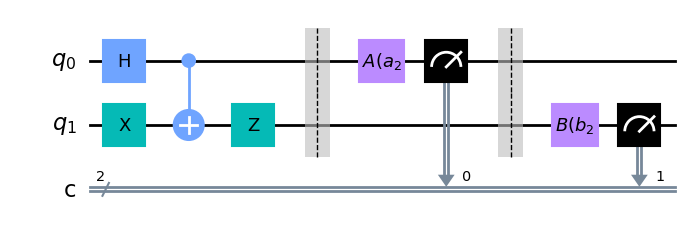


        Bit Alice:0

        Bit Bob:1
        


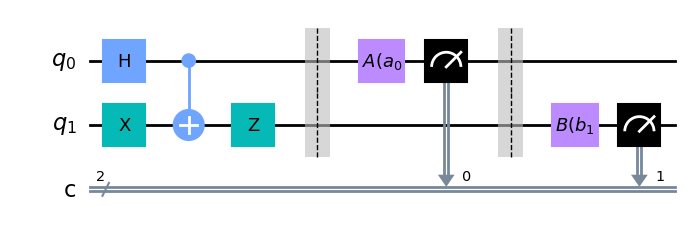

In [ ]:
for k in range(10):
  print(f'''
        Bit Alice:{resultado_medidas['Alice'][k]}

        Bit Bob:{resultado_medidas['Bob'][k]}
        '''
        )
  display(mensagem[k].draw('mpl'))

In [ ]:
print(resultado_medidas['Alice'])
print(resultado_medidas['Bob'])

[0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,

#Etapa 3: Cálculo da desigualdade de Bell

Com os resultados do passo anterior, vamos separar os bits em dois grupos

*   **Grupo 1.**   Medidas em que as projeções de spin ocorreram em direções diferentes
*   **Grupo 2.**   Medidas em que as projeções de spin ocorreram na mesma direção



Mas antes disso, até o momento estávamos utilizando a sequencia de projeções como lista de ângulos, vamos transformar em lista de vetores espaciais associados nesses ângulos, pois agora será conveniente saber se esses vetores são perpendiculares ou não

Agora sim vamos separar nossos bits:

In [ ]:
def separar_bits(resultado_medidas, escolhas_alice, escolhas_bob):
  grupo_1={'Alice':[],
           'Bob':[]
           }

  grupo_2={'Alice':[],
           'Bob':[]
           }

  i=0
  for a,b in zip(escolhas_alice,escolhas_bob):
    if (a==1 and b==0) or (a==2 and b==1):
      grupo_2['Alice'].append(resultado_medidas['Alice'][i])
      grupo_2['Bob'].append(resultado_medidas['Bob'][i])
      # escolhas_alice=delete(escolhas_alice,i)
      # escolhas_bob=delete(escolhas_bob,i)
    else:
      grupo_1['Alice'].append(resultado_medidas['Alice'][i])
      grupo_1['Bob'].append(resultado_medidas['Bob'][i])
    i+=1

  return grupo_1, grupo_2




In [ ]:
grupo1,grupo2=separar_bits(resultado_medidas, escolhas_alice, escolhas_bob)

Podemos ver a seguir que todos os bits estão anticorrelacionados

In [ ]:
print(grupo2['Alice'])
print(grupo2['Bob'])

[1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1]
[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0]


De posse dos dois grupos, agora é possível calcular a quantidade $S$

In [ ]:
def calcular_S(grupo1, escolhas_alice,escolhas_bob):
  #Cadalinha armazzena a quantidade de vezes que foi utilizado a_i e b_j simultaneamente na medida
  #Cada coluna corresponde aos resultados '00'-'11'-'01'-'10', respectivamente

  a1b1=[0,   0,   0,  0]
  a1b3=[0,   0,   0,  0]
  a3b1=[0,   0,   0,  0]
  a3b3=[0,   0,   0,  0]

  B=['00','11','01','10']

  i=0
  for bita,bitb in zip(grupo1['Alice'],grupo1['Bob']):

    a=escolhas_alice[i]
    b=escolhas_bob[i]

    #Verifica se as projeções são paralelas, se elas forem, pula essa medida
    while ((a==1 and b==0) or (a==2 and b==1)):
        i+=1
        a=escolhas_alice[i]
        b=escolhas_bob[i]

    result=str(bita)+str(bitb) #Concatena o bit de Bob com o de Alice

    if (a==0 and b==0): #Verifica se é uma medida simultanea a1 e b1
      for j in range(4):
        if B[j]==result: #Verifica se o resultado é 00,11,01,10
          a1b1[j]+=1  #

    if (a==0 and b==2):
      for j in range(4):
        if B[j]==result:
          a1b3[j]+=1

    if (a==2 and b==0):
      for j in range(4):
        if B[j]==result:
          a3b1[j]+=1

    if (a==2 and b==2):
      for j in range(4):
        if B[j]==result:
          a3b3[j]+=1

    i+=1

  num11=sum(a1b1) #Número total de vezes que foi feita a projeção em a_1 e b_1
  num13=sum(a1b3) #Número total de vezes que foi feita a projeção em a_1 e b_3
  num31=sum(a3b1) #Número total de vezes que foi feita a projeção em a_3 e b_1
  num33=sum(a3b3) #Número total de vezes que foi feita a projeção em a_3 e b_3

  Ea1b1=(a1b1[0] + a1b1[1] - a1b1[2] - a1b1[3])/num11 #Correlação E(a_1,b_1)
  Ea1b3=(a1b3[0] + a1b3[1] - a1b3[2] - a1b3[3])/num13 #Correlação E(a_1,b_3)
  Ea3b1=(a3b1[0] + a3b1[1] - a3b1[2] - a3b1[3])/num31 #Correlação E(a_3,b_1)
  Ea3b3=(a3b3[0] + a3b3[1] - a3b3[2] - a3b3[3])/num33 #Correlação E(a_3,b_3)

  S=Ea1b1-Ea1b3+Ea3b1+Ea3b3

  return S

In [ ]:
S=calcular_S(grupo1, escolhas_alice,escolhas_bob)

In [ ]:
S

-2.715170278637771

#Protocolo com invasor

In [ ]:
# Determinação das diferentes direções que alice projetará o spin
a1=[pi/2,0]
a2=[pi/2,pi/4]
a3=[pi/2,pi/2]
vetores_alice=[a1,a2,a3]
operador_alice=obter_rotacoes(vetores_alice)

# Determinação das diferentes direções que bob projetará o spin
b1=[pi/2,pi/4]
b2=[pi/2,pi/2]
b3=[pi/2,3*pi/4]
vetores_bob=[b1,b2,b3]
operador_bob=obter_rotacoes(vetores_bob)

# Determinação das diferentes direções que eve projetará o spin
e1=[pi/2,pi/4]
e2=[pi/2,pi/2]
vetores_eve=[e1,e2]
operador_eve=obter_rotacoes(vetores_bob)


# ------------------------Etapa 1---------------------------------
n=300
mensagem=[]
for i in range(n):
  qc=QuantumCircuit(2,4)
  mensagem.append(qc)

criar_EPR(mensagem) #Criação dos n pares emaranhados

# ------------------------Etapa 2---------------------------------
escolhas_eve=randint(2, size=n) #ev decide sua sequencia de medida
escolhas_alice=randint(3, size=n) #Alice decide sua sequencia de medida
escolhas_bob=randint(3, size=n) #Bob decide sua sequencia de medida

medir_qbit(mensagem, escolhas_eve, operador_eve, qbit=0,cbit=2,text='RE_') #Eve projeta o qbit1
medir_qbit(mensagem, escolhas_eve, operador_eve, qbit=1,cbit=3,text='RE_') #Eve projeta o qbit2

medir_qbit(mensagem, escolhas_alice, operador_alice, qbit=0,cbit=0,text='A(a_') #Alcie realiza a projeção
medir_qbit(mensagem, escolhas_bob, operador_bob, qbit=1,cbit=1,text='B(b_') #Bob realiza a projeção

resultado_medidas=simular_mensagem (mensagem, usuarios=['Eve_a', 'Eve_b','Alice', 'Bob'])


grupo1,grupo2=separar_bits(resultado_medidas, escolhas_alice, escolhas_bob)

S=calcular_S(grupo1, escolhas_alice,escolhas_bob)
print(S)

-1.0770114942528735


In [ ]:
print(resultado_medidas['Eve_a'])
print(resultado_medidas['Eve_b'])

[1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1]
[0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,


        Bit Alice:1

        Bit Bob:1
        


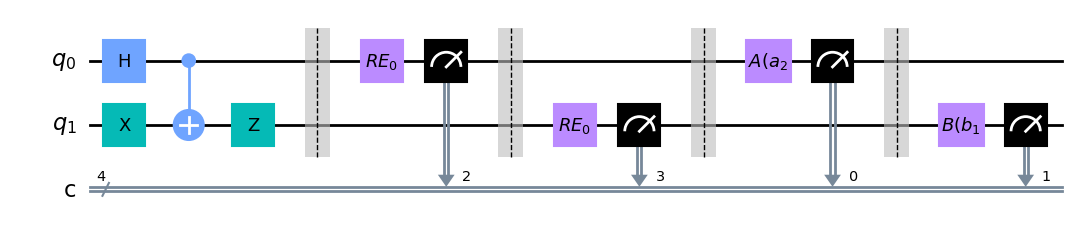


        Bit Alice:1

        Bit Bob:0
        


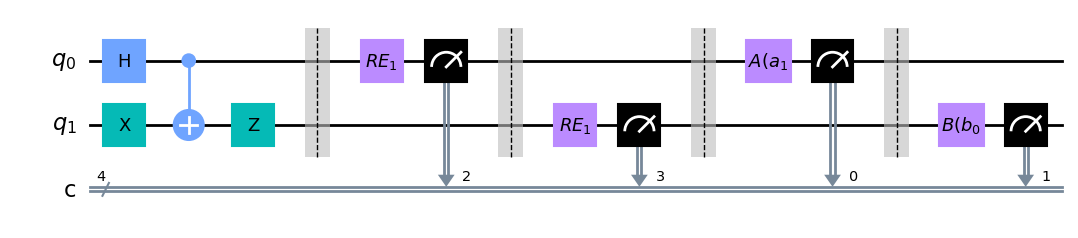


        Bit Alice:1

        Bit Bob:1
        


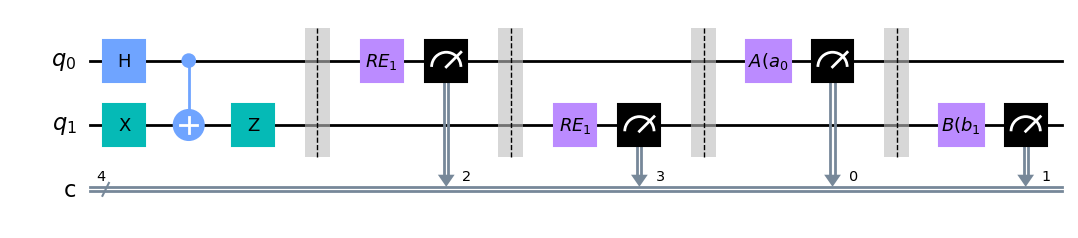


        Bit Alice:1

        Bit Bob:0
        


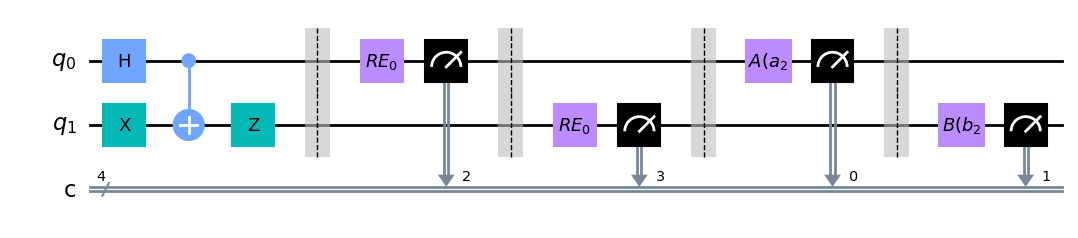


        Bit Alice:0

        Bit Bob:0
        


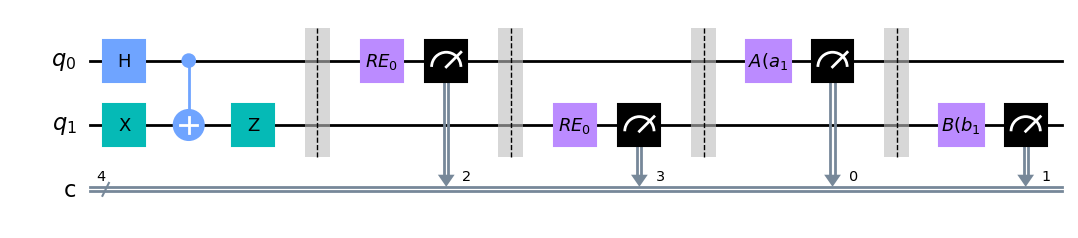


        Bit Alice:0

        Bit Bob:0
        


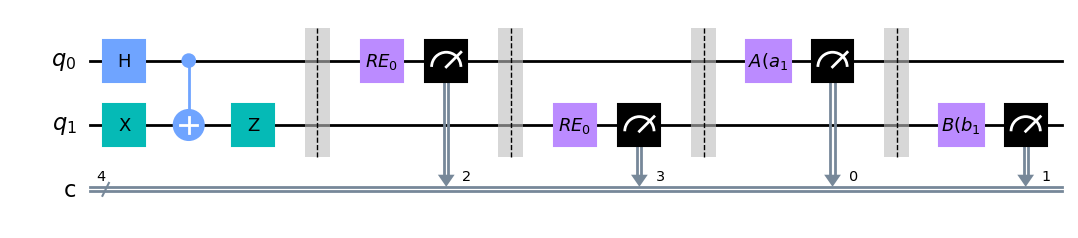


        Bit Alice:0

        Bit Bob:0
        


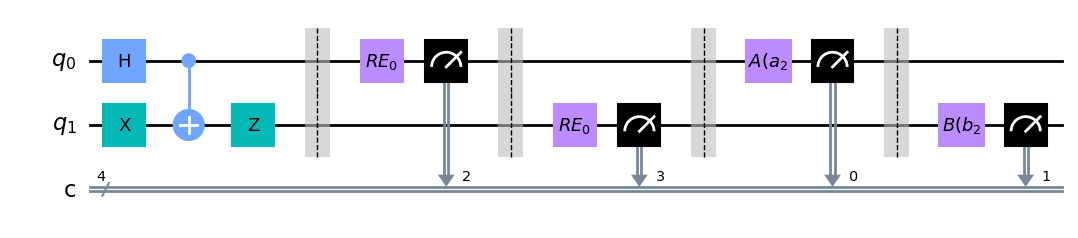


        Bit Alice:0

        Bit Bob:0
        


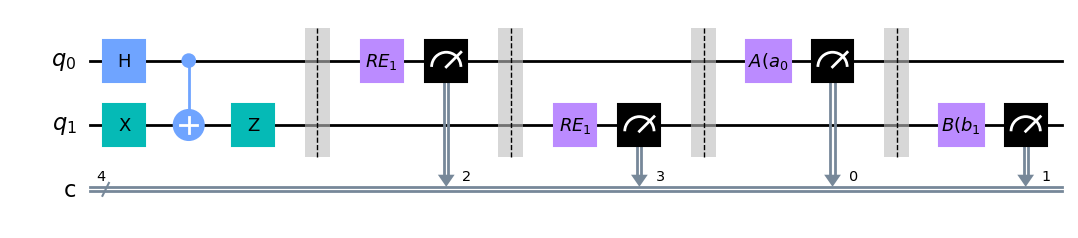


        Bit Alice:1

        Bit Bob:1
        


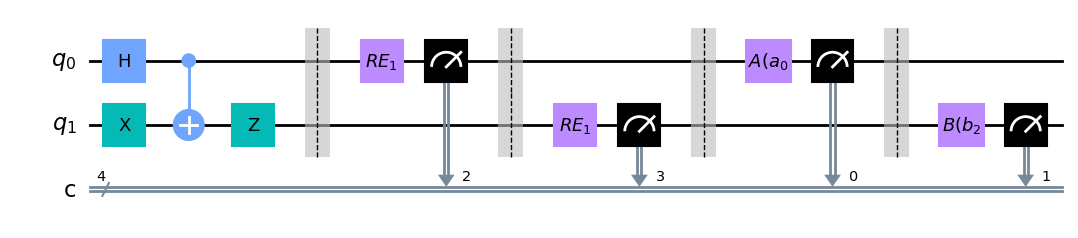


        Bit Alice:0

        Bit Bob:0
        


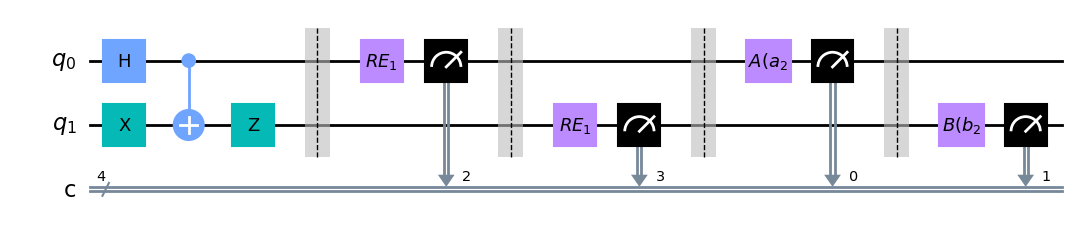

In [ ]:
for k in range(10):
  print(f'''
        Bit Alice:{resultado_medidas['Alice'][k]}

        Bit Bob:{resultado_medidas['Bob'][k]}
        '''
        )
  display(mensagem[k].draw('mpl'))

#Verificação da segurança

Executaremos o protocolo para diferentes números de pares EPR, {50,100,256}, para cada um deles o protocolo será executado 300 vezes, e veremos qual a porcentagem de vezes em que eva é detectada.

In [ ]:
Dados={}
for k in [50,100,256,350]:
  Dados[str(k)]=[]
  for j in range(150):
    a1=[pi/2,0]
    a2=[pi/2,pi/4]
    a3=[pi/2,pi/2]
    vetores_alice=[a1,a2,a3]
    operador_alice=obter_rotacoes(vetores_alice)

    # Determinação das diferentes direções que bob projetará o spin

    b1=[pi/2,pi/4]
    b2=[pi/2,pi/2]
    b3=[pi/2,3*pi/4]
    vetores_bob=[b1,b2,b3]
    operador_bob=obter_rotacoes(vetores_bob)

    # Determinação das diferentes direções que eve projetará o spin
    e1=[pi/2,pi/4]
    e2=[pi/2,pi/2]
    vetores_eve=[e1,e2]
    operador_eve=obter_rotacoes(vetores_bob)

    # ------------------------Etapa 1---------------------------------
    n=k

    mensagem=[]
    for i in range(n):
      qc=QuantumCircuit(2,4)
      mensagem.append(qc)

    criar_EPR(mensagem) #Criação dos n pares emaranhados

    # ------------------------Etapa 2---------------------------------
    escolhas_eve=randint(2, size=n) #ev decide sua sequencia de medida
    escolhas_alice=randint(3, size=n) #Alice decide sua sequencia de medida
    escolhas_bob=randint(3, size=n) #Bob decide sua sequencia de medida

    medir_qbit(mensagem, escolhas_eve, operador_eve, qbit=0,cbit=2,text='RE_') #Eve projeta o qbit1
    medir_qbit(mensagem, escolhas_eve, operador_eve, qbit=1,cbit=3,text='RE_') #Eve projeta o qbit2

    medir_qbit(mensagem, escolhas_alice, operador_alice, qbit=0,cbit=0,text='A(a_') #Alcie realiza a projeção
    medir_qbit(mensagem, escolhas_bob, operador_bob, qbit=1,cbit=1,text='B(b_') #Bob realiza a projeção

    resultado_medidas=simular_mensagem (mensagem, usuarios=['Eve_a', 'Eve_b','Alice', 'Bob'])


    grupo1,grupo2=separar_bits(resultado_medidas, escolhas_alice, escolhas_bob)

    S=calcular_S(grupo1, escolhas_alice,escolhas_bob)
    print(S)

    Dados[str(k)].append(S)

In [ ]:
dados={'50': [-2.4761904761904763, -1.580952380952381, -2.7777777777777777, -1.3333333333333333,  -0.6666666666666665, 0.39999999999999997, -2.0, -2.4761904761904763, -1.2857142857142856, -1.8611111111111112, -1.7333333333333334, -1.0833333333333333, -1.6190476190476188, -1.238095238095238, -2.253968253968254, -1.4333333333333336, -1.1142857142857143, -2.9166666666666665, 0.06666666666666671, -1.6, -2.4761904761904763, -1.3333333333333333, -1.9333333333333333, -0.6888888888888889, -1.7428571428571429, -2.8, -2.0166666666666666, -1.5833333333333335, -0.7999999999999998,  -1.4166666666666667, -1.4333333333333331, 0.09999999999999998, -1.8333333333333333, -0.7714285714285714, -2.1, -2.261904761904762, -3.0, -3.0833333333333335, -0.5666666666666668, -0.6666666666666667,  -0.7777777777777777, -1.5, -1.4428571428571428, -1.523809523809524, -2.195238095238095, -0.45714285714285724, -0.6476190476190478, 0.22222222222222227, -0.8, 0.0, -2.0142857142857142, -1.1333333333333333, -1.9004329004329001, -3.1587301587301586, -0.6166666666666667, -0.3428571428571428, -2.3095238095238093, -1.4571428571428573, -1.9285714285714286, -1.6090909090909091, -2.428571428571429, -2.7333333333333334, -0.3055555555555556, -1.6388888888888888, -0.75, -1.0452380952380953, -1.1428571428571428, -2.2857142857142856, -1.0166666666666666, -1.1666666666666667, -1.0, 0.3333333333333333, -1.283116883116883, -0.8611111111111112, -1.6666666666666667, -0.8380952380952382, -2.2285714285714286, -1.3055555555555556, -1.666666666666667, 5.551115123125783e-17, -0.6000000000000001, -1.2, -2.5, -1.3333333333333335, -1.3333333333333333, -2.35, -2.466666666666667, -0.9444444444444444, -0.8333333333333333, -2.4000000000000004, -2.0, -2.814285714285714, -1.3, -2.1666666666666665, -1.7575757575757576, -0.7333333333333333, -0.9999999999999999, -0.6666666666666666, -0.9587301587301589, -1.3809523809523812, -2.466666666666667, -1.4666666666666666, -1.76984126984127, -1.7333333333333332, -0.44999999999999996, -0.8841269841269842, -2.2, 0.06666666666666654, 0.10000000000000009, -2.1785714285714284, -1.8, -2.3333333333333335, -1.8142857142857143, -2.2222222222222223, -1.746031746031746, -1.55, -1.9404761904761905, -0.16666666666666663, -2.4, -0.712121212121212, -1.0476190476190477, -0.3428571428571429, -2.123809523809524, -1.0555555555555556, -1.4333333333333331, -0.25, -1.6666666666666665, -2.6, -2.3142857142857145, -0.8333333333333333, -1.6, -1.7, -1.5714285714285714, -1.547619047619048, -1.7575757575757576, -0.39285714285714285, -0.8666666666666667, -0.8571428571428572, -2.388888888888889, -1.9619047619047618, -1.05, -2.4285714285714284, 0.32857142857142857, -1.753968253968254, -2.5777777777777775, -1.1976190476190478, -1.9142857142857144], '100': [-1.9841269841269842, -2.142857142857143, -2.333333333333333, -0.03205128205128199, -1.6700854700854701, -2.575, -1.3589743589743588, -1.7965367965367964, -2.151515151515152, -0.8492424242424241, -1.875, -2.5515151515151517, -1.2999999999999998, -1.0317460317460319, -1.4181818181818182, -2.0464646464646465, -1.3326007326007325, -1.3038856568268333, -1.130952380952381, -0.9916083916083915, -1.4214285714285713, -1.4911616161616161, -1.8253968253968254, -1.1075757575757577, -1.709090909090909, -0.6474358974358975, -0.5916305916305917, -1.2361739567621919, -1.3753246753246755, 0.4380952380952381, -0.6853146853146854, -2.0952380952380953, -2.0649350649350646, -0.8856209150326798, -1.2454545454545456, -0.45252525252525255, -1.4322344322344323, -1.9777777777777776, -1.7539682539682537, -1.3214285714285714, -1.5737373737373737, -1.3086124401913874, -1.166666666666667, -1.7904761904761906, -0.694017094017094, -1.1194444444444445, -0.8376623376623377, -1.6183150183150183, -1.1476190476190475, -0.8, -1.5984848484848482, 0.023809523809523836, 0.0, -1.2181818181818183, -1.473809523809524, -0.9055555555555556, -2.3578947368421055, -2.105128205128205, -2.0333333333333337, -0.6999999999999997, -1.0444444444444443, -1.0945054945054944, -2.3714285714285714, -0.9956709956709956, -1.777777777777778, -1.6767676767676767, -1.5795454545454546, -1.4727272727272727, -2.061050061050061, -0.9555555555555555, -2.085714285714286, -1.780952380952381, -1.943939393939394, -1.3333333333333333, -1.9285714285714286, -1.2752136752136753, -0.5887445887445888, -1.3666666666666665, -1.8606060606060604, -0.730837789661319, -2.033333333333333, -1.8333333333333333, -0.20882352941176474, -2.1904761904761907, -1.2619047619047619, -1.4383394383394383, -0.6297036297036296, -1.926073926073926, -2.053756185335133, -1.9060939060939064, -0.766899766899767, -1.691919191919192, -1.1913919413919416, -1.5727272727272728, -2.3071428571428574, -1.549062049062049, -1.9888888888888887, -1.5238095238095237, -1.3662337662337662, -1.125, -2.4155844155844157, -1.125, -0.7632867132867134, -2.065934065934066, -1.341991341991342, -1.0254901960784315, -1.8714285714285712, -1.6643356643356646, -0.8253968253968255, -2.0, -0.9101731601731602, -1.623076923076923, -1.8142857142857145, -2.2877122877122877, -0.8108003108003107, -1.2505050505050506, -1.422222222222222, -1.3445378151260505, -1.7478632478632479, -2.1797979797979794, -0.5393939393939394, -1.3727272727272726, -1.6051282051282052, -1.3916666666666666, -2.086247086247086, -1.5465506715506718, -1.1523809523809525, -1.3214285714285714, -1.323809523809524, -1.245887445887446, -1.1626984126984128, -1.2409090909090907, -0.903921568627451, -1.690909090909091, -1.2987012987012987, -0.8692307692307691, -1.3178571428571428, -1.3085248085248085, -0.47179487179487173, -1.3515151515151516, -1.9230769230769231, -0.7456043956043956, -1.2, -0.22838827838827835, -1.6964285714285714, -1.4075414781297133, -0.8, -0.734848484848485, -0.14407814407814412, -1.7111111111111112], '256': [-1.619686188651706, -1.6540963250640672, -1.2792487684729061, -1.3329004329004328, -1.6265527065527066, -1.4517857142857145, -1.4696774193548388, -1.0585579937304075, -1.410774410774411, -1.6272727272727272, -1.6499831082408214, -0.8544117647058824, -1.5904761904761906, -1.3131080389144907, -0.8488505747126437, -1.9621533638775017, -0.636769028073376, -1.47433238268084, -0.9939801864801865, -1.7125, -1.6364255660188338, -1.3655501998104889, -1.7477385219320702, -1.2956043956043957, -1.8461538461538463, -1.5764182424916575, -1.6897297297297298, -1.4703629703629706, -1.525225416296466, -1.0155555555555555, -1.6545363681795466, -1.8263546798029555, -1.773081803254217, -1.1972655885699364, -1.7800415800415799, -1.3656741108354011, -1.1869458128078818, -1.6507566507566507, -1.7154578754578755, -1.9090655419255824, -1.306813186813187, -1.581723561296275, -1.1538461538461537, -1.8364308105687417, -1.074805068226121, -1.782017430515762, -1.8177609427609427, -1.4382440581599065, -1.4872727272727273, -1.5194327731092439, -1.271565934065934, -0.7370545496482529, -1.2555903866248694, -1.107706570501489, -1.641001716001716, -1.3834939254294094, -1.035472972972973, -1.553190053190053, -1.7292307692307691, -0.7003456221198157, -1.2601731601731603, -1.7090597558363676, -1.6170187921912063, -1.7191882527635702, -1.3246498599439775, -0.8254406130268199, -1.1609686609686611, -1.5261071972974085, -1.2857820547573868, -0.9966491841491842, -1.7125862068965518, -1.9358358358358358, -1.7220380194518123, -1.3980189392483247, -2.0036869448634156, -1.5223665223665224, -1.2952380952380953, -0.9825709095658162, -1.2876957985653636, -1.2127339901477834, -1.2532477010655378, -1.4017511520737327, -1.2609318996415768, -0.9960130718954249, -1.2151361882282419, -1.5478896103896105, -1.2062586650821947, -1.3393717393717393, -1.4103425559947298, -1.787878787878788, -1.099780701754386, -1.6346153846153846, -1.3454545454545457, -1.4636363636363636, -0.9844625112917795, -0.8892450142450143, -1.6662814538676607, -1.5337732919254656, -1.2405476524410608, -1.8070054945054947, -1.4365079365079365, -2.0577915376676987, -1.551957671957672, -1.6653176930596287, -1.5105042016806722, -1.838013838013838, -1.1818840579710144, -1.3264038231780166, -1.2905982905982907, -1.3036383442265798, -1.6780137909170167, -1.5789711632453567, -1.8876767676767678, -1.3562881562881561, -0.7967816091954023, -1.3535087719298247, -1.6585186669338143, -1.349172140120416, -1.174048174048174, -2.1004962779156324, -1.4308080808080808, -1.4446210074686159, -1.4878483835005574, -1.3837092731829574, -0.8152574812916369, -1.2303123399897593, -1.0552749940819064, -1.0280952380952382, -1.3787577639751554, -1.7624913213148508, -1.836780185758514, -1.6274949826673966, -1.5749312523225567, -0.9441647597254004, -1.712105263157895, -1.2101584342963654, -1.37027417027417, -1.8152777777777778, -1.7303951962016477, -1.1667232597623092, -1.7516233766233764, -1.6080583812472358, -0.9945054945054945, -1.2593504834884146, -1.827622696588214, -0.9303530053155241, -1.302873563218391, -1.4268264474573857, -1.3150696895437426, -1.0729270729270728], '350': [-1.5454994617785316, -1.0824374952213471, -1.3971551765669412, -1.5400956570311408, -2.0444671607462306, -1.6815628815628814, -1.2822652964708183, -1.1641601035710434, -1.296814296814297, -1.3076479076479077, -1.5736085053158222, -1.164705882352941, -1.2751752116417852, -1.5208320850915709, -1.5036347517730497, -1.2726719161856461, -1.3160156445870732, -1.4998964872737666, -1.3197313094713912, -1.7604752970606627, -1.8892857142857145, -1.1285714285714283, -1.8909245436911837, -1.7965367965367964, -0.9865335718994255, -1.674574240479247, -1.1140322855439135, -1.1131020754031768, -1.6535628885700624, -1.4653583030355184, -1.0584330143540672, -1.724494236122143, -1.121964571690035, -1.9365079365079363, -1.8611404212214577, -1.2507864255232675, -1.1636830520909758, -1.2775047775047776, -1.4787610050767945, -1.8965566714490676, -1.7439149997289534, -1.458443602031328, -1.5054526042858232, -1.6097541659792112, -1.4447195257905756, -1.5737440066708357, -1.5621029317479747, -1.3304941304941305, -1.5156448586818374, -1.268116236537289, -1.1449016100178893, -1.4667137041857088, -1.4436334730452378, -1.334877734877735, -0.9260719605547192, -1.8583521260254272, -1.5081828740365326, -1.1108109943631088, -1.6023944875107665, -1.3821406000621272, -1.497791747259832, -1.6687523389651049, -1.4588744588744589, -1.4764798651330995, -1.7845919145690312, -1.4952038356755082, -1.4227799227799227, -1.5480127186009538, -1.1254804226562891, -1.2953900709219857, -1.4322305764411027, -1.5109521285991874, -1.145049595049595, -1.9090545502229217, -1.3749919880354664, -1.4178616002572446, -1.2731601731601734, -1.037995337995338, -1.4977215766689451, -0.5823804573804572, -1.653539483772042, -1.0321646018876254, -1.2091400662829233, -1.2731142124255466, -1.1447637468914065, -1.2234204392099128, -1.593316966721222, -1.6960657465976616, -1.429843288666818, -1.6391763191763191, -0.8196226180097148, -1.3805786555786554, -1.7636022514071297, -1.545088355719585, -1.6427833148763382, -0.8883494861359176, -1.1712132828411896, -1.3661254277533348, -1.046886446886447, -0.9198879551820729, -1.2908892525913802, -1.4711989300224595, -1.2018243807717492, -0.8884836427939873, -1.384991996987101, -1.425593761077632, -1.255442044915729, -1.2901761177623245, -1.5011494252873565, -1.5929308067465962, -2.1386090511410205, -1.431490078548902, -1.4299703430138213, -1.630223435101484, -1.3305759200496041, -1.3036374720585246, -1.40291415901172, -1.4528266536331051, -1.7757271422981609, -1.185580973710873, -1.628862885646656, -1.0817648768312904, -1.1702960640891675, -1.3815800279214911, -1.4234011595202916, -1.5106782106782108, -1.6108170927945646, -1.762198937696511, -1.5828609986504725, -1.4634920634920636, -1.5606060606060606, -1.323478689332348, -1.0716299204671296, -1.494532279314888, -1.4403958614484929, -1.4221447888495942, -1.3516908212560388, -1.4346586646661665, -1.102981029810298, -1.2453843453843456, -0.8983951249955604, -1.4696969696969697, -1.5057673489831593, -1.8545766545766544, -0.9863636363636363, -1.3512964638218377, -1.9865591397849465, -1.5307230307230308, -1.172064677584575, -1.8121408499651328]}

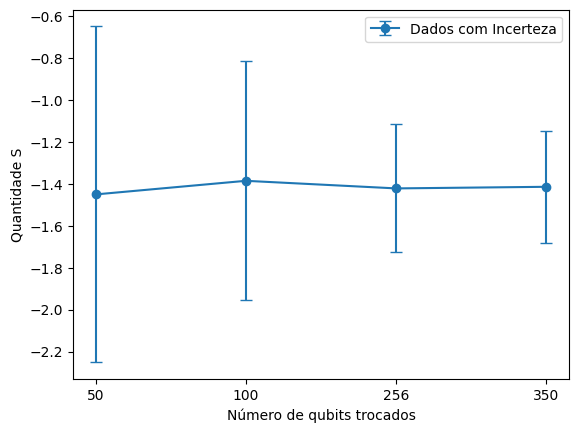

In [ ]:
list_y = []
incertezas = []
for key in dados:
  y=mean(dados[key])
  y_error=std(dados[key])

  incertezas.append(y_error)
  list_y.append(y)

list_x = dados.keys()

plt.errorbar(list_x, list_y, yerr=incertezas, label='Dados com Incerteza', fmt='-o', capsize=4)

plt.xlabel('Número de qubits trocados')
plt.ylabel('Quantidade S')



plt.legend()
plt.show()